In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ML
from regression import PCovR, KPCovR, SparseKPCovR
from regression import KRR
from kernels import build_kernel, linear_kernel, gaussian_kernel
from kernels import center_kernel, center_kernel_fast
from kernels import center_kernel_oos, center_kernel_oos_fast

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.kernel_ridge import KernelRidge

# Utilities
import h5py
import json
from tqdm.notebook import tqdm
from project_utils import load_structures_from_hdf5

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


In [3]:
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/kernel-tutorials')
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/analysis/scripts')
#from utilities.sklearn_covr.kpcovr import KernelPCovR as KPCovR2
#from utilities.sklearn_covr.pcovr import PCovR as PCovR2
from helpers import l_regr, l_kpcovr

In [4]:
def df_to_class(df, df_type, n_classes, use_df_sums=True):
    """
        Make class predictions based on a decision function.
        Based on the sci-kit learn SVC prediction, see
        `sklearn.multiclass._ovr_decision_function` 
        (sci-kit learn licensed under BSD 3-Clause license)
        
        ---Arguments---
        df: decision function on which to make class predictions
        df_type: decision function type, 'ovo' or 'ovr'
        n_classes: number of integer classes
        use_df_sums: augment the 'ovo' vote counts with
            decision function values (useful for tie breaks)
            
        ---Returns---
        predicted_class: predicted integer class
    """
    
    predicted_class = None
    
    # Approximation to the number of classes, should be valid up to at least 1M
    #n_classes = int(np.sqrt(2*df.shape[-1])) + 1
    
    if df_type == 'ovo':
        vote_matrix = np.zeros((df.shape[0], n_classes))
        df_sum = np.zeros((df.shape[0], n_classes))

        # Predicted class determined by majority vote
        col_idx = 0
        for i in range(0, n_classes):
            for j in range(i + 1, n_classes):
                col_train = df[:, col_idx]
                vote_matrix[col_train > 0, i] += 1
                vote_matrix[col_train <= 0, j] += 1

                # Add value of decision function
                if use_df_sums:
                    df_sum[:, i] += df[:, col_idx]
                    df_sum[:, j] -= df[:, col_idx]

                col_idx += 1

        # sci-kit learn transformation from 'ovo' to 'ovr'
        if use_df_sums:
            transformed_df_sum = df_sum / (3 * (np.abs(df_sum) + 1))
            vote_matrix += transformed_df_sum

        predicted_class = np.argmax(vote_matrix, axis=1) + 1

    elif df_type == 'ovr':

        # Predicted class determined by largest value of the decision function
        predicted_class = np.argmax(df, axis=1) + 1
        
    else:
        print("Error: invalid decision function. Use 'ovo' or 'ovr'")
        
    return predicted_class

# Load data

In [5]:
# Load train and test set indices for Deem
idxs_deem = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)

# Total number of structures
n_deem = idxs_deem.size + np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int).size

In [6]:
# Select DEEM sample for training/testing (already shuffled)
n_deem_train = 5000
n_deem_test = 2750
idxs_deem_train = idxs_deem[0:n_deem_train]
idxs_deem_test = idxs_deem[n_deem_train:n_deem_train+n_deem_test]

In [7]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [8]:
# Load IZA cantons
cantons_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0][0]
cantons_iza = np.delete(cantons_iza, RWY)
n_iza = len(cantons_iza)

In [9]:
# Select IZA sample
idxs_iza = np.arange(0, n_iza)
idxs_iza_train = np.arange(0, n_iza)
idxs_iza_test = np.arange(0, n_iza)

In [10]:
# Make dummy DEEM cantons
cantons_deem = np.ones(n_deem, dtype=int) * 4

# Load SOAPs and build kernels

In [11]:
# Flag to recompute existing kernels
remove_kernels = False

In [12]:
K_train = {}
K_test = {}
K_test_test = {}
kernel_type = {}
gamma = {}

In [13]:
for cutoff in cutoffs:
    kernel_file = f'../Processed_Data/Models/{cutoff}/structure_kernels_optimization.hdf5'
    
    # Start fresh
    if remove_kernels and os.path.exists(kernel_file):
        os.remove(kernel_file)
    
    # Load the kernels if they exist
    try:
        f = h5py.File(kernel_file, 'r')
        
        K_train[cutoff] = f['K_train'][:]
        K_test[cutoff] = f['K_test'][:]
        K_test_test[cutoff] = f['K_test_test'][:]
        kernel_type[cutoff] = f.attrs['kernel_type']
        gamma[cutoff] = f.attrs['gamma']
        
        # Don't need to store indices in a dictonary
        # since they are the same for all cutoffs
        idxs_iza_train = f.attrs['idxs_iza_train']
        idxs_iza_test = f.attrs['idxs_iza_test']
        idxs_deem_train = f.attrs['idxs_deem_train']
        idxs_deem_test = f.attrs['idxs_deem_test']
 
        f.close()
    
    # Compute the kernels if they don't exist
    except OSError:
    
        # Load kernel parameters
        model_file = f'../Processed_Data/Models/{cutoff}/volumes_mae_parameters.json'

        with open(model_file, 'r') as f:
            model_dict = json.load(f)

        kernel_type[cutoff] = model_dict['kernel_type']
        gamma[cutoff] = model_dict['gamma']

        # Load SOAPs
        deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
        deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)

        iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
        iza_soaps = load_structures_from_hdf5(iza_file, datasets=None, concatenate=False)
        iza_soaps.pop(RWY)

        # Build the collection of soap vectors
        # for the "master" kernel
        deem_train = [deem_soaps[i] for i in idxs_deem_train]
        deem_test = [deem_soaps[i] for i in idxs_deem_test]
        iza = [iza_soaps[i] for i in idxs_iza]

        # Build "master" kernel between all DEEM and all IZA
        K_train[cutoff] = build_kernel(iza+deem_train, iza+deem_train, 
                                       kernel=kernel_type[cutoff], gamma=gamma[cutoff])
        K_test[cutoff] = build_kernel(iza+deem_test, iza+deem_train, 
                                      kernel=kernel_type[cutoff], gamma=gamma[cutoff])
        K_test_test[cutoff] = build_kernel(iza+deem_test, iza+deem_test, 
                                           kernel=kernel_type[cutoff], gamma=gamma[cutoff])
        
        # Save kernels for later
        g = h5py.File(kernel_file, 'w')
        
        g.create_dataset('K_train', data=K_train[cutoff])
        g.create_dataset('K_test', data=K_test[cutoff])
        g.create_dataset('K_test_test', data=K_test_test[cutoff])
        
        g.attrs['idxs_iza_train'] = idxs_iza_train
        g.attrs['idxs_iza_test'] = idxs_iza_test
        g.attrs['idxs_deem_train'] = idxs_deem_train
        g.attrs['idxs_deem_test'] = idxs_deem_test
        g.attrs['kernel_type'] = kernel_type[cutoff]
        g.attrs['gamma'] = gamma[cutoff]
        
        g.close()

In [14]:
# Build set of "master" canton labels
cantons_train = np.concatenate((cantons_iza, cantons_deem[idxs_deem_train]))
cantons_test = np.concatenate((cantons_iza, cantons_deem[idxs_deem_test]))

# Set test and train subsets

## Optimization

In [15]:
n_subsets = 5

In [16]:
# Split DEEM into subsets for optimization and validation
idxs_deem_train_kernel = np.arange(idxs_iza_train.size, idxs_iza_train.size+idxs_deem_train.size)
np.random.shuffle(idxs_deem_train_kernel)
idxs_deem_train_kernel = np.split(idxs_deem_train_kernel, n_subsets)

idxs_deem_test_kernel = np.arange(idxs_iza_test.size, idxs_iza_test.size+idxs_deem_test.size)
np.random.shuffle(idxs_deem_test_kernel)
idxs_deem_test_kernel = np.split(idxs_deem_test_kernel, n_subsets)

In [17]:
# Split IZA into subsets for optimization and validation
idxs_iza = np.arange(0, n_iza)
n_iza_train_kernel = int(n_iza / 2)
n_iza_test_kernel = n_iza - n_iza_train_kernel

idxs_iza_train_kernel = []
idxs_iza_test_kernel = []
for n in range(0, n_subsets):
    np.random.shuffle(idxs_iza)
    idxs_iza_train_kernel.append(idxs_iza[0:n_iza_train_kernel])
    idxs_iza_test_kernel.append(idxs_iza[n_iza_train_kernel:])

In [18]:
# Concatenate the DEEM and IZA indices
idxs_train_kernel = [np.concatenate((iza, deem)) for iza, deem in 
                     zip(idxs_iza_train_kernel, idxs_deem_train_kernel)]
idxs_test_kernel = [np.concatenate((iza, deem)) for iza, deem in
                    zip(idxs_iza_test_kernel, idxs_deem_test_kernel)]

## Model evaluation

In [19]:
# IZA indices for training and testing
idxs_iza = np.arange(0, n_iza)
n_iza_train = int(n_iza / 2)
n_iza_test = n_iza - n_iza_train

np.random.shuffle(idxs_iza)
idxs_iza_train_all = idxs_iza[0:n_iza_train]
idxs_iza_test_all = idxs_iza[n_iza_train:]

In [20]:
# DEEM indices for training and testing
idxs_deem_train_all = np.concatenate(idxs_deem_train_kernel)
idxs_deem_test_all = np.concatenate(idxs_deem_test_kernel)

In [21]:
# Concatenate the DEEM and IZA indices
idxs_train_all = np.concatenate((idxs_iza_train_all, idxs_deem_train_all))
idxs_test_all = np.concatenate((idxs_iza_test_all, idxs_deem_test_all))

# Optimize SVM

In [22]:
df_type = 'ovo'
class_weight = None #'balanced' #{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0E-3}

In [23]:
C = np.logspace(-5, 5, 11)
class_accuracy_train = np.zeros((C.size, n_subsets))
class_accuracy_test = np.zeros((C.size, n_subsets))

In [24]:
for cutoff in cutoffs:
    for cdx, c in enumerate(C):    
        for n in range(0, n_subsets):

            # Assemble kernels
            idxs_train = idxs_train_kernel[n]
            k_train = K_train[cutoff][idxs_train, :][:, idxs_train]

            idxs_test = idxs_test_kernel[n]
            k_test = K_test[cutoff][idxs_test, :][:, idxs_train]

            # Center and scale kernels
            k_test = center_kernel_fast(k_test, K_ref=k_train)
            k_train = center_kernel_fast(k_train)

            k_scale = np.trace(k_train) / k_train.shape[0]
            k_train /= k_scale
            k_test /= k_scale

            # Assemble properties
            y_train = cantons_train[idxs_train]
            y_test = cantons_test[idxs_test]

            # SVC
            svc = SVC(kernel='precomputed', decision_function_shape=df_type, 
                      class_weight=class_weight, C=c)
            svc.fit(k_train, y_train)

            class_accuracy_train[cdx, n] = svc.score(k_train, y_train)
            class_accuracy_test[cdx, n] = svc.score(k_test, y_test)

    class_accuracy_mean_train = np.mean(class_accuracy_train, axis=1)
    class_accuracy_mean_test = np.mean(class_accuracy_test, axis=1)
    
    idx_C = np.argmax(class_accuracy_mean_test)
    C_opt = C[idx_C]
    
    print(cutoff, C_opt)
    print(class_accuracy_mean_train[idx_C])
    print(class_accuracy_mean_test[idx_C])
    
    # TODO: save matrix of classification accuracies with C

    # Save SVC parameters
    svc_parameters = dict(df_type=df_type,
                          class_weight=class_weight,
                          C=C_opt)

    model_dir = f'../Processed_Data/Models/{cutoff}'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)    
        
    with open(f'{model_dir}/ksvc_parameters.json', 'w') as f:
        json.dump(svc_parameters, f)

3.5 100.0
0.9661870503597122
0.9010558069381599
6.0 10.0
0.9892086330935251
0.9221719457013574


# SVM on full test and train sets

In [25]:
df_train = {}
df_test = {}

In [26]:
for cutoff in cutoffs:
    
    model_dir = f'../Processed_Data/Models/{cutoff}'
    with open(f'{model_dir}/ksvc_parameters.json', 'r') as f:
        model_dict = json.load(f)
    
    # Assemble kernels
    k_train = K_train[cutoff][idxs_train_all, :][:, idxs_train_all]
    k_test = K_test[cutoff][idxs_test_all, :][:, idxs_train_all]

    # Since we need decision functions for all IZA structures in the train set,
    # predict all structures based on the truncated train set above
    k_train_all = K_train[cutoff][:, idxs_train_all]
    k_test_all = K_test[cutoff][:, idxs_train_all]

    k_test = center_kernel_fast(k_test, K_ref=k_train)
    k_test_all = center_kernel_fast(k_test_all, K_ref=k_train)
    k_train_all = center_kernel_fast(k_train_all, K_ref=k_train)
    k_train = center_kernel_fast(k_train)

    k_scale = np.trace(k_train) / k_train.shape[0]
    k_test /= k_scale
    k_test_all /= k_scale
    k_train_all /= k_scale
    k_train /= k_scale

    # Assemble properties
    y_train = cantons_train[idxs_train_all]
    y_test = cantons_test[idxs_test_all]

    # SVC
    svc = SVC(kernel='precomputed', decision_function_shape=model_dict['df_type'], 
              class_weight=model_dict['class_weight'], C=model_dict['C'])
    svc.fit(k_train, y_train)
    
    print(svc.score(k_train, y_train))
    print(svc.score(k_test, y_test))

    df_train[cutoff] = svc.decision_function(k_train_all) 
    df_test[cutoff] = svc.decision_function(k_test_all)
    
    # TODO: save decision functions
    
    # Test KRR on decision functions
    # NOTE: KRR can't predict the test set
    # decision function very well -- why?
    df_krr_train = svc.decision_function(k_train)
    df_krr_test = svc.decision_function(k_test)

    df_krr_center = np.mean(df_krr_train, axis=0)
    df_krr_train -= df_krr_center
    df_krr_test -= df_krr_center

    df_krr_scale = np.linalg.norm(df_krr_train, axis=0) \
        / np.sqrt(df_krr_train.shape[0] / df_krr_train.shape[1])
    df_krr_train /= df_krr_scale
    df_krr_test /= df_krr_scale

#     krr = KernelRidge(alpha=1.0E-12, kernel='precomputed')
#     krr.fit(k_train, df_krr_train)
#     dfp_krr_train = krr.predict(k_train)
#     dfp_krr_test = krr.predict(k_test)

    krr = KRR(reg=1.0E-12)
    krr.fit(k_train, df_krr_train)
    dfp_krr_train = krr.transform(k_train)
    dfp_krr_test = krr.transform(k_test)
    
    print(np.mean(np.abs(dfp_krr_train - df_krr_train), axis=0))
    print(np.mean(np.abs(dfp_krr_test - df_krr_test), axis=0))
    print(svc.class_weight_)

0.9898278560250391
0.9717079986028642
[4.48135212e-12 2.89246573e-12 6.27716027e-12 8.85175919e-11
 8.30683331e-11 1.42645666e-10]
[2.42614866e-09 1.91023760e-09 3.61850321e-09 5.11510185e-08
 4.24256090e-08 8.29718454e-08]
[1. 1. 1. 1.]
0.9982394366197183
0.9769472581208523
[7.22382960e-14 6.88891035e-14 5.43254090e-14 9.07309411e-14
 5.88677610e-14 1.33110069e-13]
[3.39936915e-13 2.06699610e-13 1.78761111e-13 7.22249160e-13
 4.54686441e-13 4.85492672e-13]
[1. 1. 1. 1.]


# Optimize KPCovR

In [27]:
# KPCovR parameters
alphas = np.linspace(0.0, 1.0, 11)
regularizations = np.logspace(-12, -1, 12)
n_components = 2


0.9 1e-12


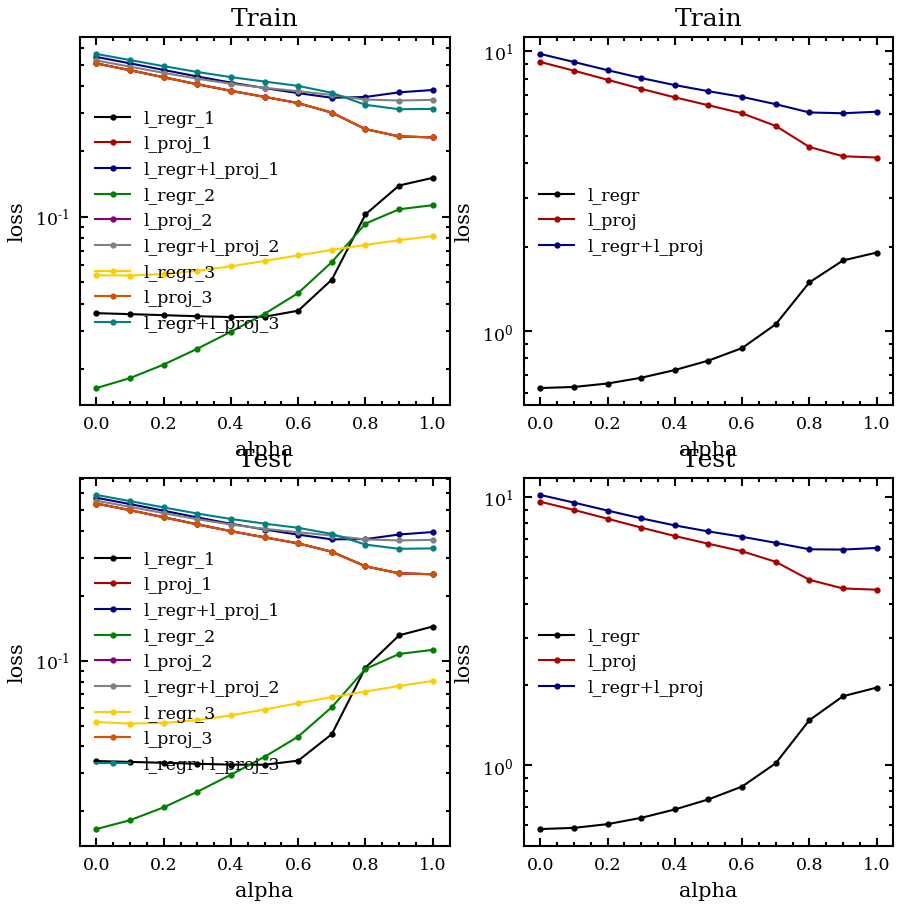


0.8 0.1


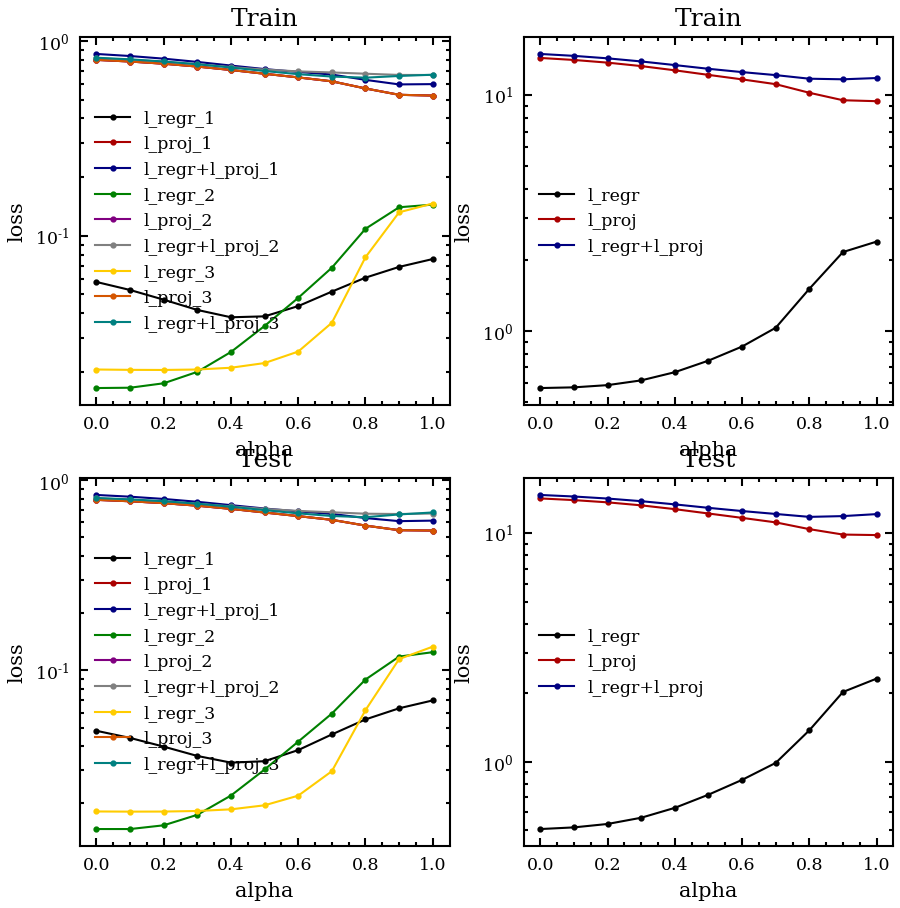

In [30]:
for cutoff in cutoffs:
    
    # Initialize matrices of losses
    n_cols = df_train[cutoff].shape[1]
    lrs_train = np.zeros((alphas.size, regularizations.size, n_cols))
    lks_train = np.zeros((alphas.size, regularizations.size, n_cols))
    lrs_test = np.zeros((alphas.size, regularizations.size, n_cols))
    lks_test = np.zeros((alphas.size, regularizations.size, n_cols))
    ltrs_train = np.zeros((alphas.size, regularizations.size))
    ltks_train = np.zeros((alphas.size, regularizations.size))
    ltrs_test = np.zeros((alphas.size, regularizations.size))
    ltks_test = np.zeros((alphas.size, regularizations.size))
    
    # TODO: load decision functions
        
    # Determine optimal alpha and regularization
    for adx, alpha in enumerate(tqdm(alphas)):
        for rdx, r in enumerate(tqdm(regularizations, leave=False)):
            for n in tqdm(range(0, n_subsets), leave=False):

                # Assemble kernels
                idxs_train = idxs_train_kernel[n]
                k_train = K_train[cutoff][idxs_train, :][:, idxs_train]

                idxs_test = idxs_test_kernel[n]
                k_test = K_test[cutoff][idxs_test, :][:, idxs_train]
                k_test_test = K_test_test[cutoff][idxs_test, :][:, idxs_test]

                k_test_test = center_kernel_oos_fast(k_test_test, k_test, k_train)
                k_test = center_kernel_fast(k_test, K_ref=k_train)
                k_train = center_kernel_fast(k_train)

                k_scale = np.trace(k_train) / k_train.shape[0]
                k_test_test /= k_scale
                k_test /= k_scale
                k_train /= k_scale

                # Assemble properties
                y_train = df_train[cutoff][idxs_train]
                y_test = df_test[cutoff][idxs_test]            

                y_center = np.mean(y_train, axis=0)
                y_train = y_train - y_center
                y_test = y_test - y_center

                y_scale = np.linalg.norm(y_train, axis=0) \
                    / np.sqrt(y_train.shape[0] / y_train.shape[1])
                y_train = y_train / y_scale
                y_test = y_test / y_scale

                # KPCovR fit and predictions
                # Already scaled, so omit here to speed things up
#                 kpcovr = KPCovR2(mixing=alpha, n_components=n_components, kernel='precomputed', 
#                                  krr_params=dict(alpha=r))
#                 kpcovr.fit(k_train, y_train)

#                 t_train = kpcovr.transform(k_train)
#                 yp_train = kpcovr.predict(k_train)
#                 t_test = kpcovr.transform(k_test)
#                 yp_test = kpcovr.predict(k_test)

                kpcovr = KPCovR(alpha=alpha, n_components=n_components, regularization=r)
                kpcovr.fit(k_train, y_train)

                t_train = kpcovr.transform_K(k_train)
                yp_train = kpcovr.transform_Y(k_train)
                t_test = kpcovr.transform_K(k_test)
                yp_test = kpcovr.transform_Y(k_test)

                # Collect regression and projection (KPCovR) losses for each canton
                lrs_test[adx, rdx, :] += l_regr(y_test, yp_test)
                lks_test[adx, rdx, :] += l_kpcovr(k_train=k_train,
                                            k_test=k_test,
                                            k_test_test=k_test_test,
                                            t_train=t_train, t_test=t_test)

                lrs_train[adx, rdx, :] += l_regr(y_train, yp_train)
                lks_train[adx, rdx, :] += l_kpcovr(k_train=k_train,
                                             t_train=t_train, t_test=t_test)

                # Total loss as sum of cantonwise losses
                ltrs_train[adx, rdx] += np.sum(lrs_train[adx, rdx, :])
                ltks_train[adx, rdx] += np.sum(lks_train[adx, rdx, :])

                ltrs_test[adx, rdx] += np.sum(lrs_test[adx, rdx, :])
                ltks_test[adx, rdx] += np.sum(lks_test[adx, rdx, :])


            # Average over the folds
            lrs_test[adx, rdx, :] /= n_subsets
            lks_test[adx, rdx, :] /= n_subsets

            ltrs_test[adx, rdx] /= n_subsets
            ltks_test[adx, rdx] /= n_subsets

            lrs_train[adx, rdx, :] /= n_subsets
            lks_train[adx, rdx, :] /= n_subsets

            ltrs_train[adx, rdx] /= n_subsets
            ltks_train[adx, rdx] /= n_subsets
            
    # Extract optimal hyperparameters
    opt_alpha_idx, opt_reg_idx = np.unravel_index(np.argmin(ltrs_test+ltks_test, axis=None), 
                                                  (ltrs_test+ltks_test).shape)
    
    opt_alpha = alphas[opt_alpha_idx]
    opt_reg = regularizations[opt_reg_idx]
    
    print(opt_alpha, opt_reg)
    
    # Save KPCovR parameters
    kpcovr_parameters = dict(n_components=n_components,
                             regularization=opt_reg,
                             alpha=opt_alpha)

    model_dir = f'../Processed_Data/Models/{cutoff}'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)    
        
    with open(f'{model_dir}/kpcovr_parameters.json', 'w') as f:
        json.dump(kpcovr_parameters, f)

    fig = plt.figure(figsize=(7.0, 7.0))
    axs_loss_train = fig.add_subplot(2, 2, 1)
    axs_loss_sum_train = fig.add_subplot(2, 2, 2)
    axs_loss_test = fig.add_subplot(2, 2, 3)
    axs_loss_sum_test = fig.add_subplot(2, 2, 4)
    
    # Cantonwise losses for the train set
    for i in range(0, 3):
        axs_loss_train.semilogy(alphas, lrs_train[:, opt_reg_idx, i], 'o-', label=f'l_regr_{i+1}')
        axs_loss_train.semilogy(alphas, lks_train[:, opt_reg_idx, i], 'o-', label=f'l_proj_{i+1}')
        axs_loss_train.semilogy(alphas, lrs_train[:, opt_reg_idx, i]+lks_train[:, opt_reg_idx, i], 
                 'o-', label=f'l_regr+l_proj_{i+1}')

    axs_loss_train.legend()
    axs_loss_train.set_title('Train')
    axs_loss_train.set_xlabel('alpha')
    axs_loss_train.set_ylabel('loss')

    # Sum of projection and regression loss over all cantons for the train set
    axs_loss_sum_train.semilogy(alphas, ltrs_train[:, opt_reg_idx], 'o-', label='l_regr')
    axs_loss_sum_train.semilogy(alphas, ltks_train[:, opt_reg_idx], 'o-', label='l_proj')
    axs_loss_sum_train.semilogy(alphas, ltrs_train[:, opt_reg_idx]+ltks_train[:, opt_reg_idx], 
                            'o-', label='l_regr+l_proj')
    
    axs_loss_sum_train.legend()
    axs_loss_sum_train.set_title('Train')
    axs_loss_sum_train.set_xlabel('alpha')
    axs_loss_sum_train.set_ylabel('loss')
    
    # Cantonwise losses for the test set
    for i in range(0, 3):
        axs_loss_test.semilogy(alphas, lrs_test[:, opt_reg_idx, i], 'o-', label=f'l_regr_{i+1}')
        axs_loss_test.semilogy(alphas, lks_test[:, opt_reg_idx, i], 'o-', label=f'l_proj_{i+1}')
        axs_loss_test.semilogy(alphas, lrs_test[:, opt_reg_idx, i]+lks_test[:, opt_reg_idx, i], 
                 'o-', label=f'l_regr+l_proj_{i+1}')

    axs_loss_test.legend()
    axs_loss_test.set_title('Test')
    axs_loss_test.set_xlabel('alpha')
    axs_loss_test.set_ylabel('loss')

    # Sum of projection and regression loss over all cantons for the test set
    axs_loss_sum_test.semilogy(alphas, ltrs_test[:, opt_reg_idx], 'o-', label='l_regr')
    axs_loss_sum_test.semilogy(alphas, ltks_test[:, opt_reg_idx], 'o-', label='l_proj')
    axs_loss_sum_test.semilogy(alphas, ltrs_test[:, opt_reg_idx]+ltks_test[:, opt_reg_idx], 'o-', label='l_regr+l_proj')
    
    axs_loss_sum_test.legend()
    axs_loss_sum_test.set_title('Test')
    axs_loss_sum_test.set_xlabel('alpha')
    axs_loss_sum_test.set_ylabel('loss')
    
    plt.show()

In [31]:
# KPCovR on full test and train sets (TODO: move to separate notebook)

In [32]:
# TODO: load KPCovR parameters

In [33]:
T_train = {}
yp_train = {}
predicted_cantons_train = {}

T_test = {}
yp_test = {}
predicted_cantons_test = {}

In [34]:
for cutoff in cutoffs:

    # Assemble kernels
    k_train = K_train[cutoff][idxs_train_all, :][:, idxs_train_all]
    k_test = K_test[cutoff][idxs_test_all, :][:, idxs_train_all]

    k_test = center_kernel_fast(k_test, K_ref=k_train)
    k_train = center_kernel_fast(k_train)

    k_scale = np.trace(k_train) / k_train.shape[0]
    k_test /= k_scale
    k_train /= k_scale

    # Assemble properties
    y_train = df_train[cutoff][idxs_train_all]
    y_test = df_test[cutoff][idxs_test_all]

    y_center = np.mean(y_train, axis=0)
    y_test = y_test - y_center
    y_train = y_train - y_center

    y_scale = np.linalg.norm(y_train, axis=0) / np.sqrt(y_train.shape[0] / y_train.shape[1])
    y_test /= y_scale
    y_train /= y_scale

#     kpcovr = KPCovR2(n_components=n_components, kernel='precomputed',
#                      mixing=opt_alpha[cutoff],
#                      krr_params=dict(alpha=opt_reg[cutoff]))
#     kpcovr.fit(k_train, y_train)
#     T_train[cutoff] = kpcovr.transform(k_train)
#     yp_train[cutoff] = kpcovr.predict(k_train) 
#     T_test[cutoff] = kpcovr.transform(k_test) 
#     yp_test[cutoff] = kpcovr.predict(k_test)

    kpcovr = KPCovR(n_components=2, 
                    alpha=0.1, 
                    regularization=1.0E-12)
    kpcovr.fit(k_train, y_train)
    T_train[cutoff] = kpcovr.transform_K(k_train)
    yp_train[cutoff] = kpcovr.transform_Y(k_train)
    T_test[cutoff] = kpcovr.transform_K(k_test)
    yp_test[cutoff] = kpcovr.transform_Y(k_test)
    
    # Rescale to raw decision function
    yp_train[cutoff] = yp_train[cutoff] * y_scale + y_center
    yp_test[cutoff] = yp_test[cutoff] * y_scale + y_center

    # Predict classes based on KPCovRized decision functions
    n_classes = np.amax(cantons_train)
    predicted_cantons_train[cutoff] = df_to_class(yp_train[cutoff], df_type, n_classes, use_df_sums=True)
    predicted_cantons_test[cutoff] = df_to_class(yp_test[cutoff], df_type, n_classes, use_df_sums=True)

    # Classification stats
    print(classification_report(cantons_train[idxs_train_all], predicted_cantons_train[cutoff]))
    print(classification_report(cantons_test[idxs_test_all], predicted_cantons_test[cutoff]))
    print(confusion_matrix(cantons_train[idxs_train_all], predicted_cantons_train[cutoff]))
    print(confusion_matrix(cantons_test[idxs_test_all], predicted_cantons_test[cutoff]))

              precision    recall  f1-score   support

           1       0.50      0.19      0.27        16
           2       0.62      0.57      0.59        65
           3       0.50      0.06      0.11        31
           4       0.99      1.00      0.99      5000

    accuracy                           0.99      5112
   macro avg       0.65      0.46      0.49      5112
weighted avg       0.98      0.99      0.98      5112

              precision    recall  f1-score   support

           1       0.33      0.05      0.09        19
           2       0.49      0.37      0.42        57
           3       0.80      0.11      0.19        37
           4       0.98      1.00      0.99      2750

    accuracy                           0.97      2863
   macro avg       0.65      0.38      0.42      2863
weighted avg       0.96      0.97      0.96      2863

[[   3    5    0    8]
 [   3   37    2   23]
 [   0   13    2   16]
 [   0    5    0 4995]]
[[   1    5    0   13]
 [   2   21   

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


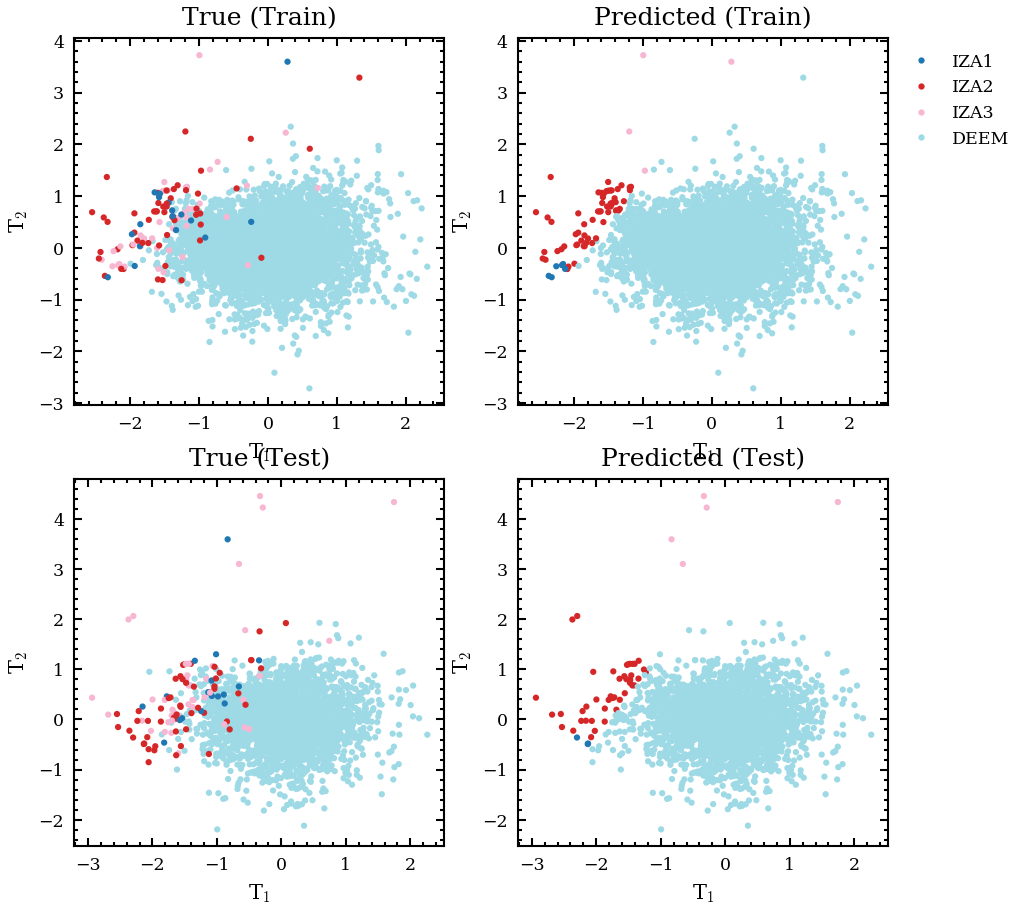

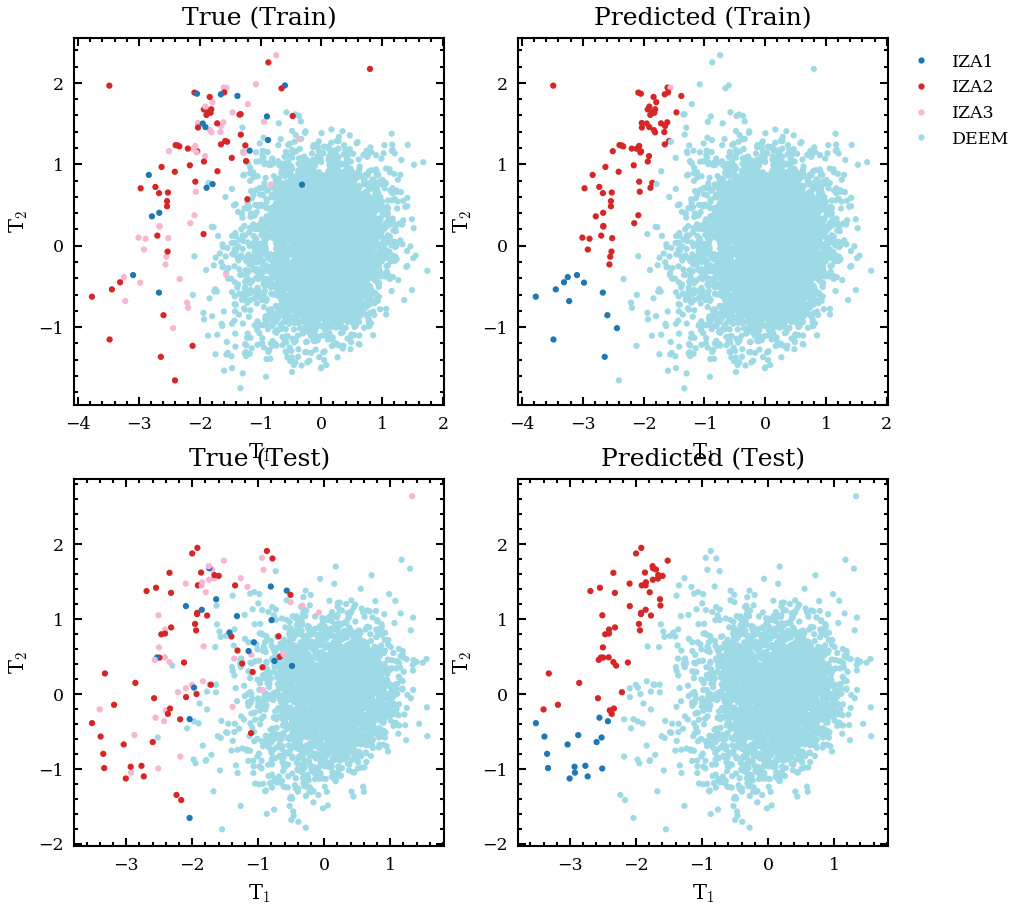

In [35]:
for cutoff in cutoffs:
    
    fig = plt.figure(figsize=(7.0, 7.0))
    axs_true_train = fig.add_subplot(2, 2, 1)
    axs_predicted_train = fig.add_subplot(2, 2, 2)
    axs_true_test = fig.add_subplot(2, 2, 3)
    axs_predicted_test = fig.add_subplot(2, 2, 4)
    scatter_opts = dict(cmap='tab20', vmin=1, vmax=4)

    axs_true_train.scatter(T_train[cutoff][n_iza_train:, 0], T_train[cutoff][n_iza_train:, 1], 
                c=cantons_train[n_iza:], zorder=2, **scatter_opts)
    axs_true_train.scatter(T_train[cutoff][0:n_iza_train, 0], T_train[cutoff][0:n_iza_train, 1], 
                c=cantons_train[0:n_iza_train], zorder=3, **scatter_opts)

    axs_predicted_train.scatter(T_train[cutoff][n_iza_train:, 0], T_train[cutoff][n_iza_train:, 1], 
                c=predicted_cantons_train[cutoff][n_iza_train:], zorder=2, **scatter_opts)
    axs_predicted_train.scatter(T_train[cutoff][0:n_iza_train, 0], T_train[cutoff][0:n_iza_train, 1], 
                c=predicted_cantons_train[cutoff][0:n_iza_train], zorder=3, **scatter_opts)
    
    axs_true_test.scatter(T_test[cutoff][n_iza_test:, 0], T_test[cutoff][n_iza_test:, 1],
            c=cantons_test[n_iza:], zorder=2, **scatter_opts)
    axs_true_test.scatter(T_test[cutoff][0:n_iza_test, 0], T_test[cutoff][0:n_iza_test, 1],
            c=cantons_test[0:n_iza_test], zorder=3, **scatter_opts)
    
    axs_predicted_test.scatter(T_test[cutoff][n_iza_test:, 0], T_test[cutoff][n_iza_test:, 1],
            c=predicted_cantons_test[cutoff][n_iza_test:], zorder=2, **scatter_opts)
    axs_predicted_test.scatter(T_test[cutoff][0:n_iza_test, 0], T_test[cutoff][0:n_iza_test, 1],
            c=predicted_cantons_test[cutoff][0:n_iza_test], zorder=3, **scatter_opts)

    handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
               Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
               Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
               Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]

    labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
    axs_predicted_train.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

    for ax in (axs_true_train, axs_predicted_train, axs_true_test, axs_predicted_test):
        ax.set_xlabel(r'T$_1$')
        ax.set_ylabel(r'T$_2$')
        
    axs_true_train.set_title('True (Train)')
    axs_predicted_train.set_title('Predicted (Train)')
    axs_true_test.set_title('True (Test)')
    axs_predicted_test.set_title('Predicted (Test)')

    #fig.savefig(f'../Results/{cutoff}/svm-kpcovr.png', bbox_inches='tight')

    plt.show()